In [2]:
from importlib import reload
import astropy.units as u

import os
import glob

import grizli
from grizli import utils,fitting, multifit, prep, model
# python stuff
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from astropy.io import fits
# import drizzlepac
from astropy.table import Table
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MultipleLocator
from matplotlib import gridspec
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from astropy.stats import sigma_clipped_stats
from petrofit.modeling import fit_model
from astropy.modeling import models
from petrofit.modeling import get_default_sersic_bounds
from petrofit.modeling import PSFConvolvedModel2D
import sys
import random
from astropy.modeling import models,fitting
from astropy import modeling
from scipy.ndimage import gaussian_filter
from scipy.stats import normaltest
import numpy as np
from scipy.stats import kstest
import scipy.stats as stats
import copy
from reproject import reproject_exact,reproject_adaptive
from sedpy.observate import load_filters,Filter
from scipy.interpolate import interp1d
from astropy.coordinates import SkyCoord
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["image.origin"] = 'lower'
sys.path.append("/data/home/zihaoli/my_tools/")
utils.set_warnings()
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
from photutils.segmentation import (detect_sources,make_2dgaussian_kernel)
from astropy.convolution import convolve
from scipy.ndimage import rotate
import astropy.constants as c
from astropy.cosmology import FlatLambdaCDM
from matplotlib.cm import ScalarMappable
import zg_utils
from astropy.convolution import Gaussian2DKernel, convolve
from matplotlib.ticker import MaxNLocator
cosmos = FlatLambdaCDM(Om0=0.3,H0=70)

2024-11-13 18:34:42,743 - stpipe - WARNING - /home/zihaoli/miniconda3/envs/grizli39/lib/python3.9/site-packages/tweakwcs/tpwcs.py:27: AstropyDeprecationWarning: Module 'tweakwcs.tpwcs' has been deprecated since version 0.8.0. Please use corrector classes from the 'tweakwcs.correctors' module.
  warnings.warn(

2024-11-13 18:34:43,485 - stpipe - WARNING - /home/zihaoli/miniconda3/envs/grizli39/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED



In [3]:
%load_ext autoreload
%autoreload 2

# Load extracted 2D spectra

In [14]:
line_hdu = fits.open('gds_31418.full.fits')
# mb = multifit.MultiBeam('gds_31418.beams.fits')
beam_hdu = fits.open('gds_31418.beams.fits')
PA = beam_hdu['SCI'].header['PA_V3']-270

line_data = line_hdu['LINE','Ha']
ref_data = line_hdu['DSCI']
linewht_data = line_hdu['LINEWHT','Ha']

In [16]:
# Subtract emission line flux from direct image

this_filter = Filter('jwst_f444w')
Filter_wv = this_filter.wavelength
Filter_trans_tr = this_filter.transmission
Filter_tr = interp1d(Filter_wv, Filter_trans_tr, fill_value=0)
tr_scaling_factor = np.trapz(Filter_trans_tr / Filter_wv, Filter_wv) * 2.99792458E+18 
tr_line = Filter_tr(42000)
f_line = (line_hdu[0].header['FLUX001'] * tr_line * 42000) / tr_scaling_factor
f_line = (f_line * u.erg/u.cm**2/u.s/u.Hz ).to(u.uJy)

In [17]:
coord = SkyCoord(line_hdu[0].header['RA']*u.deg,line_hdu[0].header['DEC']*u.deg)

# Load images

In [18]:
f444w = fits.open('/home/zihaoli/data/public/FRESCO/v1.2.3/psf-matched/FRESCO-f444w_drz_sci_resample_psfmatch.fits')
f210m = fits.open('/home/zihaoli/data/public/FRESCO/v1.2.3/psf-matched/FRESCO-f210m_drz_sci_resample_psfmatch.fits')


wcs_f444w = WCS(f444w[0].header)
wcs_f210m = WCS(f210m[0].header)

f444w_cut = Cutout2D(f444w[0].data,coord,(133,133),wcs_f444w).data
f210m_cut = Cutout2D(f210m[0].data,coord,(133,133),wcs_f210m).data

ref_data = f444w_cut-f210m_cut

ref_data = np.nan_to_num(ref_data,0)

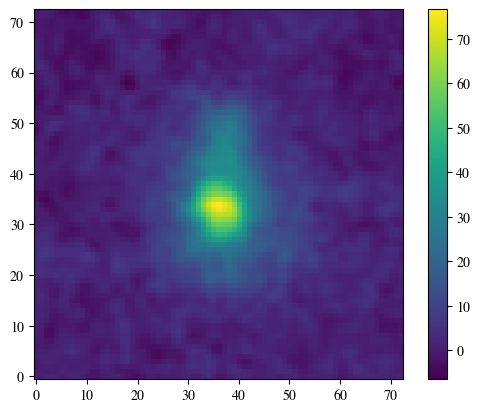

In [19]:
ref_sm_cgs = (ref_data*u.uJy).to(u.erg/u.cm**2/u.s/u.AA,equivalencies=u.spectral_density( 44043.* u.AA))
ref_sm_cgs = 1e17*ref_sm_cgs*10676*u.AA/0.03**2
ref_sm_cgs = ref_sm_cgs.value
plt.imshow(ref_sm_cgs[30:-30,30:-30])
plt.colorbar()

# Fit model to image to get basic morphological parameters

In [27]:
psf = fits.getdata('F444W_psf_30mas.fits')

sersic_model = models.Sersic2D(

        amplitude=0.01, # Intensity at r_eff
        r_eff=2, # Effective or half-lilght radius
        n=1, # Sersic index
        x_0=66, # center of model in the x direction
        y_0=66, # center of model in the y direction
        ellip=0.3, # Ellipticity
        theta=0.1, # Rotation angle in radians, counterclockwise from the positive x-axis.

)
gaussian_model = models.Gaussian2D(
    amplitude=0.01, x_mean=14, y_mean=15,
)
psf_sersic_model = PSFConvolvedModel2D(sersic_model, psf=psf, oversample=1)

line_model, fitter = fit_model(
    image=line_data.data,
    model=sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

sersic_model = models.Sersic2D(

        amplitude=0.01, # Intensity at r_eff
        r_eff=2, # Effective or half-lilght radius
        n=2, # Sersic index
        x_0=66, # center of model in the x direction
        y_0=66, # center of model in the y direction
        ellip=0.3, # Ellipticity
        theta=0.1, # Rotation angle in radians, counterclockwise from the positive x-axis.

)

seg1 = line_hdu['seg'].data.copy()
seg1 = seg1.astype(np.float32)
seg1[seg1!=seg1[66,66]] = 0

seg1[seg1==seg1[66,66]] /= seg1[66,66]

ref_model, fitter = fit_model(
    image=ref_data*seg1,
    model=psf_sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

# only fit sersic to match center
ref_model_center, fitter = fit_model(
    image=ref_data*seg1,
    model=sersic_model,
    maxiter=10000,
    epsilon=1.4901161193847656e-08,
    acc=1e-09,
)

2024-11-13 18:46:41,980 - stpipe - WARNING - /home/zihaoli/miniconda3/envs/grizli39/lib/python3.9/site-packages/petrofit/modeling/models.py:374: UserWarning: Input PSF not normalized to 1, current sum = 1.0000001192092896
  warnings.warn("Input PSF not normalized to 1, current sum = {}".format(psf.sum()))



In [28]:
x_0 = ref_model.x_0.value
y_0 = ref_model.y_0.value
ellip = ref_model.ellip.value
# theta = ref_model.theta.value

ref_theta = ref_model.theta.value
# if ref_model.theta.value > 0:
#     ref_theta = ref_model.theta.value - np.floor(ref_model.theta.value /(2*np.pi))*np.pi
# else:
#     ref_theta = ref_model.theta.value - np.ceil(ref_model.theta.value /(2*np.pi))*np.pi
    
r_eff = ref_model.r_eff.value
n = ref_model.n.value
if ellip < 0:
    ref_theta += np.pi/2
    a, b = r_eff, r_eff/(1-ellip)
    ellip = 1 - b/a
else:
    a, b = r_eff, (1 - ellip) * r_eff

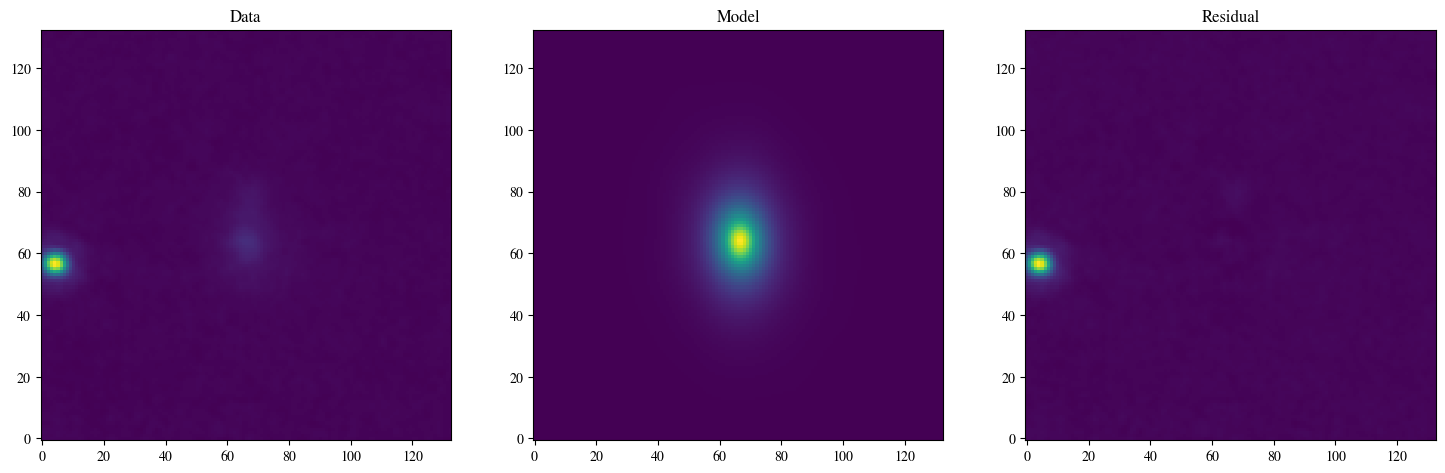

In [29]:
from petrofit.modeling import plot_fit

plot_fit(ref_model, ref_data.data, figsize=[3*6, 6])
plt.show()

# Match line spread function (LSF) (assuming a Gaussian LSF) for image and grism data.

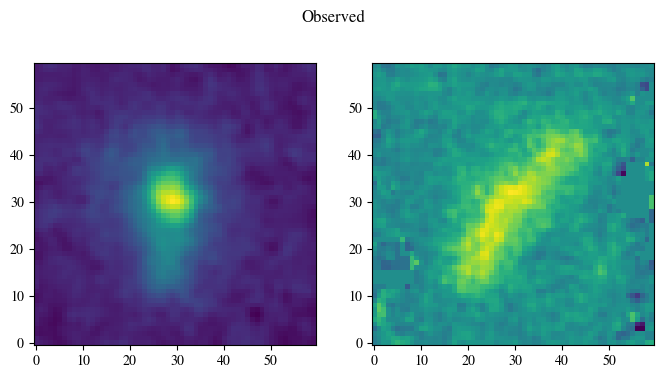

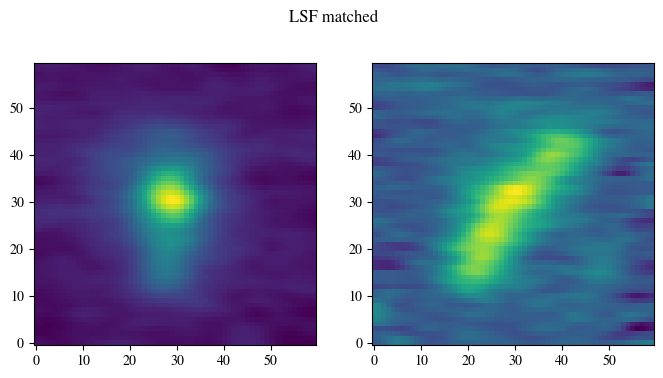

In [30]:
line_cut = Cutout2D(line_data.data,(line_model.x_0.value,line_model.y_0.value),size=(100,100)).data
linewht_cut = Cutout2D(line_hdu['LINEWHT','Ha'].data,(line_model.x_0.value,line_model.y_0.value),size=(100,100)).data

ref_cut = Cutout2D(ref_data,(ref_model.x_0.value,ref_model.y_0.value),size=(100,100)).data
# ref_cut = Cutout2D(ref_data.data,(ref_model.x_0.value,ref_model.y_0.value),size=(50,50)).data


rot_angle = list(mb.PA['F444W'].keys())[0] + 90

rot = rotate(linewht_cut,rot_angle,order=3)
sh = rot.shape
img_w = 60
linewht_cut = rot[sh[0]//2-img_w//2:sh[0]//2+img_w//2,sh[1]//2-img_w//2:sh[1]//2+img_w//2]


rot = rotate(line_cut,rot_angle,order=3)
sh = rot.shape
img_w = 60
line_cut = rot[sh[0]//2-img_w//2:sh[0]//2+img_w//2,sh[1]//2-img_w//2:sh[1]//2+img_w//2]


rot = rotate(ref_cut,rot_angle,order=3)
sh = rot.shape
img_w = 60
ref_cut = rot[sh[0]//2-img_w//2:sh[0]//2+img_w//2,sh[1]//2-img_w//2:sh[1]//2+img_w//2]


# line_sm = gaussian_filter(line_cut,0.8)
# ref_sm = gaussian_filter(ref_cut,0.8)

line_sm = np.empty_like(line_cut)
ref_sm = np.empty_like(line_cut)

sig_lsf = 46800/1650/5/2.355
for i in range(len(line_cut)):
    line_sm[i,:] = gaussian_filter(line_cut[i,:],sig_lsf)
    ref_sm[i,:] = gaussian_filter(ref_cut[i,:],sig_lsf)
    

# here apply no smooth
# line_sm  = line_cut
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(ref_cut,origin='lower')
plt.subplot(122)
plt.imshow(line_cut,origin='lower')
plt.suptitle('Observed')
plt.show()
plt.figure(figsize=(8,4))
plt.subplot(121)
plt.imshow(ref_sm,origin='lower')
plt.subplot(122)
plt.imshow(line_sm,origin='lower')
plt.suptitle('LSF matched')
plt.show()

In [31]:
s = 60
z = line_hdu['line','Ha'].header['REDSHIFT']
wave_center = 0.6564697*(1+z)
wave_start = 0.6564697*(1+z) - 0.0005*s
wave_end = 0.6564697*(1+z) + 0.0005*s

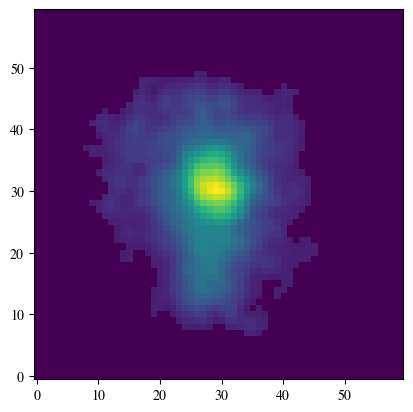

In [32]:
kernel = make_2dgaussian_kernel(1., size=11)
convolved_data = convolve(ref_cut, kernel)
mean, _, std = sigma_clipped_stats(ref_cut)
seg = detect_sources(convolved_data, 1.5*std, npixels=20,connectivity=4).data.astype(float)
plt.imshow(seg*ref_cut,origin='lower')

In [33]:
'''
Emission map resampling
'''
def row_CIC(position_x,value_x,mesh=np.zeros(60)):
    # position_x = [29]
    # value_x = [20]
    for x,val in zip(position_x,value_x):

        cell_center = np.floor(x)

        nd = np.array([0,1])
        cell_neighbors = cell_center + nd
        d = abs(x - cell_center)
        t = 1 - d
        volume = ((1-nd)*t+nd*d)*val

        cell_neighbors[cell_neighbors>=len(mesh)] -= 1
        cell_neighbors = cell_neighbors.astype(int)

        for i,n in enumerate(cell_neighbors):
            if (n >= len(mesh))|(n<0):
                continue
            mesh[n] += volume[i]
            
    return mesh

In [34]:
from scipy.interpolate import LinearNDInterpolator


# Construct the kinematic model

In [35]:
def chi_func(param,fix_arg):
    
    x,y,tanphi,phi,PA,tanphi_rot,phi_rot,linewht_cut,ref_sm,grism_PA,a,b = fix_arg
    # vrot,Rv,v0,vsig,q,norm = param
    vrot,Rv,v0,vsig,norm = param
    
    q = 0
    # i = np.arccos(b/a)
    i = np.arccos((((b/a)**2-q**2)/(1-q**2))**0.5)
    ###################
    theta = np.arctan(tanphi/np.cos(i))
    R = abs(x/np.cos(theta))
    vc = 2*vrot/np.pi*np.arctan(R/Rv)
    ###################

    V = vc*np.sin(i)/(1+(tanphi_rot/np.cos(i))**2)*np.sign(y-x*np.tan(PA+np.pi/2))+v0
    V = np.nan_to_num(V,0)
    

    V = rotate(V,-grism_PA*180/3.14,order=1,mode='constant')

    s_final = 60
    V = Cutout2D(V,(V.shape[0]/2,V.shape[1]/2),(s_final,s_final)).data


    x_orig,y_orig = np.meshgrid(np.arange(0,s_final),np.arange(0,s_final))
    dx = V*seg*wave_center*1e4/3e5/5
    lam_sig = vsig*wave_center*1e4/3e5/5
    x_rot = x_orig+dx
    position_x = x_rot
    img_v = np.zeros_like(ref_sm)

    for i in range(len(ref_sm))[:]:

        val_x = ref_sm[i,:]
        out_mesh = row_CIC(position_x[i,:],val_x,mesh=np.zeros(s_final))
        out_mesh = gaussian_filter(out_mesh,lam_sig)
        img_v[i,:] = out_mesh

    chi = np.nansum((line_sm-img_v*norm)**2*linewht_cut*seg)

    return chi

In [36]:
def imgv_func(param,fix_arg):
    
    x,y,tanphi,phi,PA,tanphi_rot,phi_rot,linewht_cut,ref_sm,grism_PA,a,b = fix_arg
    # vrot,Rv,v0,vsig,q,norm = param
    vrot,Rv,v0,vsig,norm = param

    q = 0
    i = np.arccos((((b/a)**2-q**2)/(1-q**2))**0.5)
    ###################
    theta = np.arctan(tanphi/np.cos(i))
    R = abs(x/np.cos(theta))
    vc = 2*vrot/np.pi*np.arctan(R/Rv)
    ###################

    V = vc*np.sin(i)/(1+(tanphi_rot/np.cos(i))**2)*np.sign(y-x*np.tan(PA+np.pi/2))
    V = np.nan_to_num(V,0)
    V = rotate(V,-grism_PA*180/np.pi,order=1,mode='constant')

    s_final = 60
    V = Cutout2D(V,(V.shape[0]/2,V.shape[1]/2),(s_final,s_final)).data

    
    x_orig,y_orig = np.meshgrid(np.arange(0,s_final),np.arange(0,s_final))
    dx = V*seg*wave_center*1e4/3e5/5
    lam_sig = vsig*wave_center*1e4/3e5/5
    x_rot = x_orig+dx
    position_x = x_rot
    img_v = np.zeros_like(ref_sm)

    for i in range(len(ref_sm))[:]:

        val_x = ref_sm[i,:]
        out_mesh = row_CIC(position_x[i,:],val_x,mesh=np.zeros(s_final))
        out_mesh = gaussian_filter(out_mesh,lam_sig)
        img_v[i,:] = out_mesh

    return img_v,V

In [37]:
import emcee

In [38]:
def lnprior(p):
    # The parameters are stored as a vector of values, so unpack them
    vrot,Rv,v0,vsig,norm = p

    if (vrot <= -1000)|(vrot > 1000)|(v0<-100)|(v0>100)|(norm<0)|(norm>100)|(vsig<0)|(vsig>2000)|(Rv<0):
        return -np.inf

    mu = 3.55*0.5
    sigma = 3.55*0.5
    return np.log(1.0/(np.sqrt(2*np.pi)*sigma))-0.5*(Rv-mu)**2/sigma**2

    

def lnlike(p, *fix_arg):

    lp = -0.5*chi_func(p,fix_arg)
    return lp

def lnprob(p, *fix_arg): # posterior log
    lp = lnprior(p)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(p, *fix_arg)

In [39]:
s = 60
PA = ref_theta
x,y = np.meshgrid(np.arange(0,s)-(s/2-0.5),np.arange(0,s)-(s/2-0.5))

tanphi = y/x
phi = np.arctan(tanphi)
tanphi_rot = (np.tan(-PA)+tanphi)/(1-np.tan(-PA)*tanphi)
phi_rot = np.arctan(tanphi_rot)


Nwalker,Ndim = 16,5
Nparam = Ndim
p0 = [np.array([-100,3,1,30,1])*(1+np.random.uniform(-0.5,0.5, size=Nparam)) for i in range(Nwalker)]
# grism_PA = (360 - (list(mb.PA['F444W'].keys())[0] + 90))/180*np.pi
grism_PA = (360 - PA)/180*np.pi

x,y = np.meshgrid(np.arange(0,s)-(s/2-0.5),np.arange(0,s)-(s/2-0.5))
fix_arg = [x,y,tanphi,phi,PA,tanphi_rot,phi_rot,linewht_cut,ref_sm,grism_PA,a,b]

# Fitting kinematic model to the observed 2D spectrum

In [40]:
from multiprocessing import Pool

with Pool(16) as pool:
    sampler = emcee.EnsembleSampler(Nwalker,Ndim,lnprob,args=(fix_arg),pool=pool)
    pos,prob,state = sampler.run_mcmc(p0, 500,progress=True)


100%|█████████████████████████████████████████| 500/500 [01:53<00:00,  4.40it/s]


In [41]:
burnin = 100
samples = sampler.chain[:, int(burnin):, :].reshape((-1, Ndim))
# samples = sampler.get_chain(flat=True)
params_fit = np.median(samples,axis=0)

In [42]:
tmp = line_data.data.copy()
for i in range(len(tmp)):
    tmp[i,:] = gaussian_filter(tmp[i,:],sig_lsf)
tmp[tmp==0] = np.nan
_,_,line_sig = sigma_clipped_stats(tmp,sigma=4)
line_sig

0.0006136722

In [43]:
mo_list = []
for ii in range(5):
    
    sample = samples[:,ii]
    mode = zg_utils.estmode_savgol(sample,histNbin=50, savgolWindow=11, savgolpoly=3, density=True, return_full=False)

    percnt = np.asarray([0.16, 0.5, 0.84])
    temp_percnt = percnt-.5
    temp_percnt += len(np.where(sample<=mode[0])[0])/float(len(sample))

    # replace >100% and <0% with 1. and 0.
    temp_percnt = np.ma.masked_greater(temp_percnt, 1.)
    temp_percnt = temp_percnt.filled(1.)
    temp_percnt = np.ma.masked_less(temp_percnt, 0.)
    temp_percnt = temp_percnt.filled(0.)
    mo_val  = np.percentile(sample, list(temp_percnt*100.))
    mo_list.append(mo_val)
mo_list = np.array(mo_list)

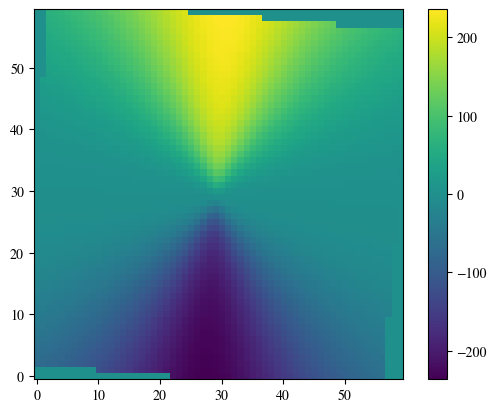

In [44]:
vsig = mo_list[3,1]*wave_center*1e4/3e5/5
vrot = mo_list[0,1]
v0 = mo_list[2,1]
Rv = mo_list[1,1]
norm = mo_list[4,1]
# img_v,V = imgv_func([vrot,Rv,v0,vsig,norm],fix_arg)
img_v,V = imgv_func(np.median(samples,axis=0),fix_arg)
# img_v,V = imgv_func([100,2,v0,vsig,norm],fix_arg)

# plt.imshow(img_v)
plt.show()
plt.imshow(V,origin='lower')
plt.colorbar()

# Display the fitted results

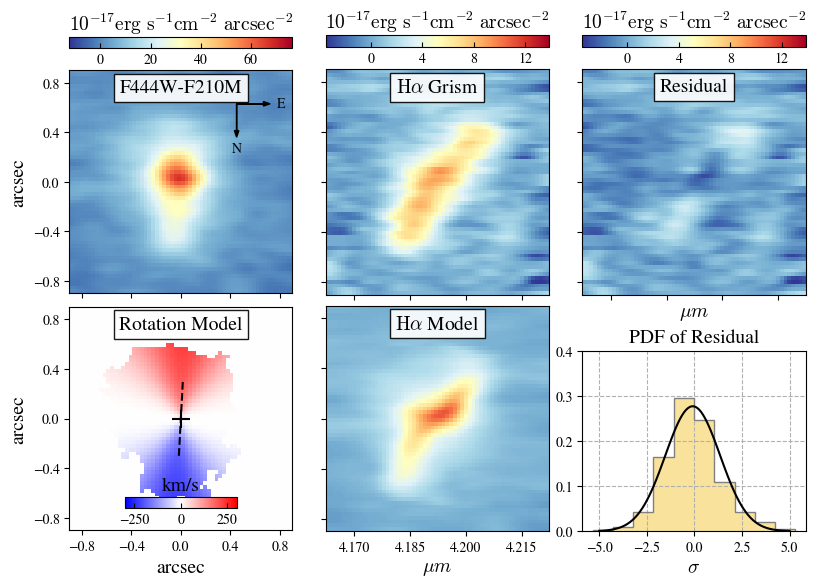

In [45]:
COLOR = 'k'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

img_v,V = imgv_func(np.median(samples,axis=0),fix_arg)

interpolation = 'None'
kernel = Gaussian2DKernel(0.8, x_size=5, y_size=5)
# test_img = convolve(ref_cut,kernel,boundary='fill')
wht_sm = 1/convolve(1/linewht_cut,kernel.array**2,boundary='wrap')

fig,ax = plt.subplots(2,3,figsize=(9.5,6.),sharey='all',sharex='col')
plt.subplots_adjust(hspace=0.05,wspace=0.15)

ref_sm_cgs = (ref_sm*u.uJy).to(u.erg/u.cm**2/u.s/u.AA,equivalencies=u.spectral_density( 44043.* u.AA))
ref_sm_cgs = 1e17*ref_sm_cgs*10676*u.AA/0.03**2
ref_sm_cgs = ref_sm_cgs.value

_, med, img_std = sigma_clipped_stats(ref_sm_cgs)
plot_vmin = med - 4*img_std
plot_vmax = med + 20*img_std
im = ax[0,0].imshow(ref_sm_cgs,cmap='RdYlBu_r',origin='lower',vmin=plot_vmin,vmax=plot_vmax,
               extent=(-s/2*0.03,s/2*0.03,-s/2*0.03,s/2*0.03),interpolation=interpolation)
cbaxes00 = ax[0,0].inset_axes([0., 1.1, 1.0, 0.05]) 
cb = plt.colorbar(im,cax=cbaxes00,orientation='horizontal')
cb.set_label(label=r'$10^{-17} \rm erg\ s^{-1} cm^{-2}\ arcsec^{-2}$',size=14,labelpad=-40)
cb.ax.tick_params(labelsize=10,direction='in')

ax[0,0].set_xlim(-s/2*0.03,s/2*0.03)
ax[0,0].set_ylim(-s/2*0.03,s/2*0.03)
ax[0,0].set_ylabel('arcsec',fontsize=14)
ax[0,0].text(0.5,0.96,'F444W-F210M',fontsize=14,transform=ax[0,0].transAxes,
             horizontalalignment='center',verticalalignment='top',bbox=dict(facecolor='white', alpha=0.9))

ax[0,1].text(0.5,0.96,r'$\rm H\alpha$ Grism',fontsize=14,transform=ax[0,1].transAxes,
             horizontalalignment='center',verticalalignment='top',bbox=dict(facecolor='white', alpha=0.9))
_, median, std = sigma_clipped_stats(line_sm/0.03**2)
plot_vmin_line = median - 3.5*std
plot_vmax_line = median + 12*std

im_line = ax[0,1].imshow(line_sm/0.03**2,origin='lower',
           extent=[wave_start,wave_end,-s/2*0.03,s/2*0.03],
             # aspect=wave_end-wave_start+0.001,
             aspect='auto',
               vmin=plot_vmin_line,vmax=plot_vmax_line,
           cmap='RdYlBu_r',interpolation=interpolation)
cbaxes01 = ax[0,1].inset_axes([0., 1.1, 1.0, 0.05]) 
cb = plt.colorbar(im_line,cax=cbaxes01,orientation='horizontal')
cb.set_label(label=r'$10^{-17} \rm erg\ s^{-1} cm^{-2}\ arcsec^{-2}$',size=14,labelpad=-40)
cb.ax.tick_params(labelsize=10,direction='in')
cb.ax.xaxis.set_major_locator(
                        MaxNLocator(5, prune="lower")
                    )
ax[1,0].plot(np.linspace(-0.016,0.016,10),np.tan(PA+grism_PA)*np.linspace(-0.016,0.016,10),c='k',ls='--')

ax[1,0].set_xlim(-s/2*0.03,s/2*0.03)
ax[1,0].set_ylim(-s/2*0.03,s/2*0.03)
ax[1,0].set_xlabel(r'arcsec',fontsize=14)
ax[1,0].scatter(0,0,marker='+',c='k',s=150)
ax[1,0].text(0.5,0.96,'Rotation Model',fontsize=14,transform=ax[1,0].transAxes,
             ha='center',va='top',bbox=dict(facecolor='white', alpha=0.9))

im = ax[1,0].imshow(V*seg,cmap='bwr',origin='lower',vmax=300,vmin=-300,
                  extent=(-s/2*0.03,s/2*0.03,-s/2*0.03,s/2*0.03), 
                 )

cbaxes1 = ax[1,0].inset_axes([0.25, 0.1, 0.5, 0.05]) 
cb = plt.colorbar(im,cax=cbaxes1,label='km/s',orientation='horizontal')
cb.set_label(label='km/s',size=14,labelpad=-35)
cb.ax.tick_params(labelsize=10,direction='in')

ax[1,1].text(0.5,0.96,r'$\rm H\alpha$ Model',fontsize=14,transform=ax[1,1].transAxes,
             horizontalalignment='center',verticalalignment='top',bbox=dict(facecolor='white', alpha=0.9))

ax[1,1].set_xlabel(r'$\mu m$',fontsize=14)

ax[1,1].imshow((img_v*params_fit[-1])/0.03**2,origin='lower',
           extent=[wave_start,wave_end,-s/2*0.03,s/2*0.03],
             # aspect=wave_end-wave_start+0.001,
             aspect='auto',
               vmin=plot_vmin_line,vmax=plot_vmax_line,
           cmap='RdYlBu_r',interpolation=interpolation)
ax[1,1].xaxis.set_major_locator(
                        MaxNLocator(6, prune="lower")
                    )
ax[0,2].xaxis.set_major_locator(
                        MaxNLocator(6, prune="lower")
                    )
ax[0,0].set_yticks([-0.8,-0.4,0,0.4,0.8])
ax[1,0].set_yticks([-0.8,-0.4,0,0.4,0.8])
ax[1,0].set_xticks([-0.8,-0.4,0,0.4,0.8])


ax[0,2].set_xlabel(r'$\mu m$',fontsize=14)
ax[0,2].text(0.5,0.96,'Residual',fontsize=14,transform=ax[0,2].transAxes,
             horizontalalignment='center',verticalalignment='top',bbox=dict(facecolor='white', alpha=0.9))

im_res = ax[0,2].imshow((line_sm-params_fit[-1]*img_v)/0.03**2,
                  extent=[wave_start,wave_end,-s/2*0.03,s/2*0.03],
                  # aspect=wave_end-wave_start+0.002,
                  aspect='auto',
                  origin='lower',cmap='RdYlBu_r',
                  vmin=plot_vmin_line,vmax=plot_vmax_line,
                  interpolation=interpolation
                 )

cbaxes3 = ax[0,2].inset_axes([0., 1.1, 1.0, 0.05])
cb = plt.colorbar(im_res,cax=cbaxes3,
                  orientation='horizontal',)

cb.set_label(label=r'$10^{-17} \rm erg\ s^{-1} cm^{-2}\ arcsec^{-2}$',size=14,labelpad=-40)
cb.ax.tick_params(labelsize=10,direction='in')
cb.ax.xaxis.set_major_locator(
                        MaxNLocator(5, prune="lower")
                    )

ax[1,0].set_ylabel(r'arcsec',fontsize=14)

arrow_center = [0.75,0.85]
arrow_length = 0.15
theta = - rot_angle
dx = arrow_length*np.cos(np.deg2rad(theta+90))
dy = arrow_length*np.sin(np.deg2rad(theta+90))
ax[0,0].arrow(arrow_center[0], arrow_center[1],dx,dy,head_width=0.02,color='k',
            transform=ax[0,0].transAxes,length_includes_head=True,)

dx_text = (arrow_length+0.05)*np.cos(np.deg2rad(theta+90))
dy_text = (arrow_length+0.05)*np.sin(np.deg2rad(theta+90))
ax[0,0].text(arrow_center[0]+dx_text,arrow_center[1]+dy_text,'N',transform=ax[0,0].transAxes,ha='center',va='center')

dx = arrow_length*np.cos(np.deg2rad(theta+180))
dy = arrow_length*np.sin(np.deg2rad(theta+180))
ax[0,0].arrow(arrow_center[0], arrow_center[1],dx,dy,head_width=0.02,color='k',
            transform=ax[0,0].transAxes,length_includes_head=True)

dx_text = (arrow_length+0.05)*np.cos(np.deg2rad(theta+180))
dy_text = (arrow_length+0.05)*np.sin(np.deg2rad(theta+180))

ax[0,0].text(arrow_center[0]+dx_text,arrow_center[1]+dy_text,'E',transform=ax[0,0].transAxes,ha='center',va='center')
tmp = line_data.data.copy()
for i in range(len(tmp)):
    tmp[i,:] = gaussian_filter(tmp[i,:],sig_lsf)
tmp[tmp==0] = np.nan
_,_,line_sig = sigma_clipped_stats(tmp,sigma=4)

plt.delaxes(ax[1,2])
res = ((line_sm-params_fit[-1]*img_v)/line_sig).flatten()

ax_hist = ax[0,2].inset_axes([0., -1.05, 1, 0.8])

ax_hist.hist(res,bins=10,color='#f9e29c',density=True)
ax_hist.hist(res,bins=10,color='gray',histtype='step',density=True,)
from scipy.stats import norm
res = np.delete(res,np.where(np.isnan(res)))
mu, std = norm.fit(res)
x = np.linspace(-5, 5, 100)
p = norm.pdf(x, mu, std)
ax_hist.plot(x, p, 'k', linewidth=1.5)
ax_hist.set_xlabel(r'$\sigma$',fontsize=14)
ax_hist.set_ylim(0,0.4)
ax_hist.set_title('PDF of Residual',fontsize=14)
ax_hist.grid(ls='--')
# plt.savefig('rot_model_Ha.pdf',bbox_inches='tight')

# Show the posterior distribution of model parameters

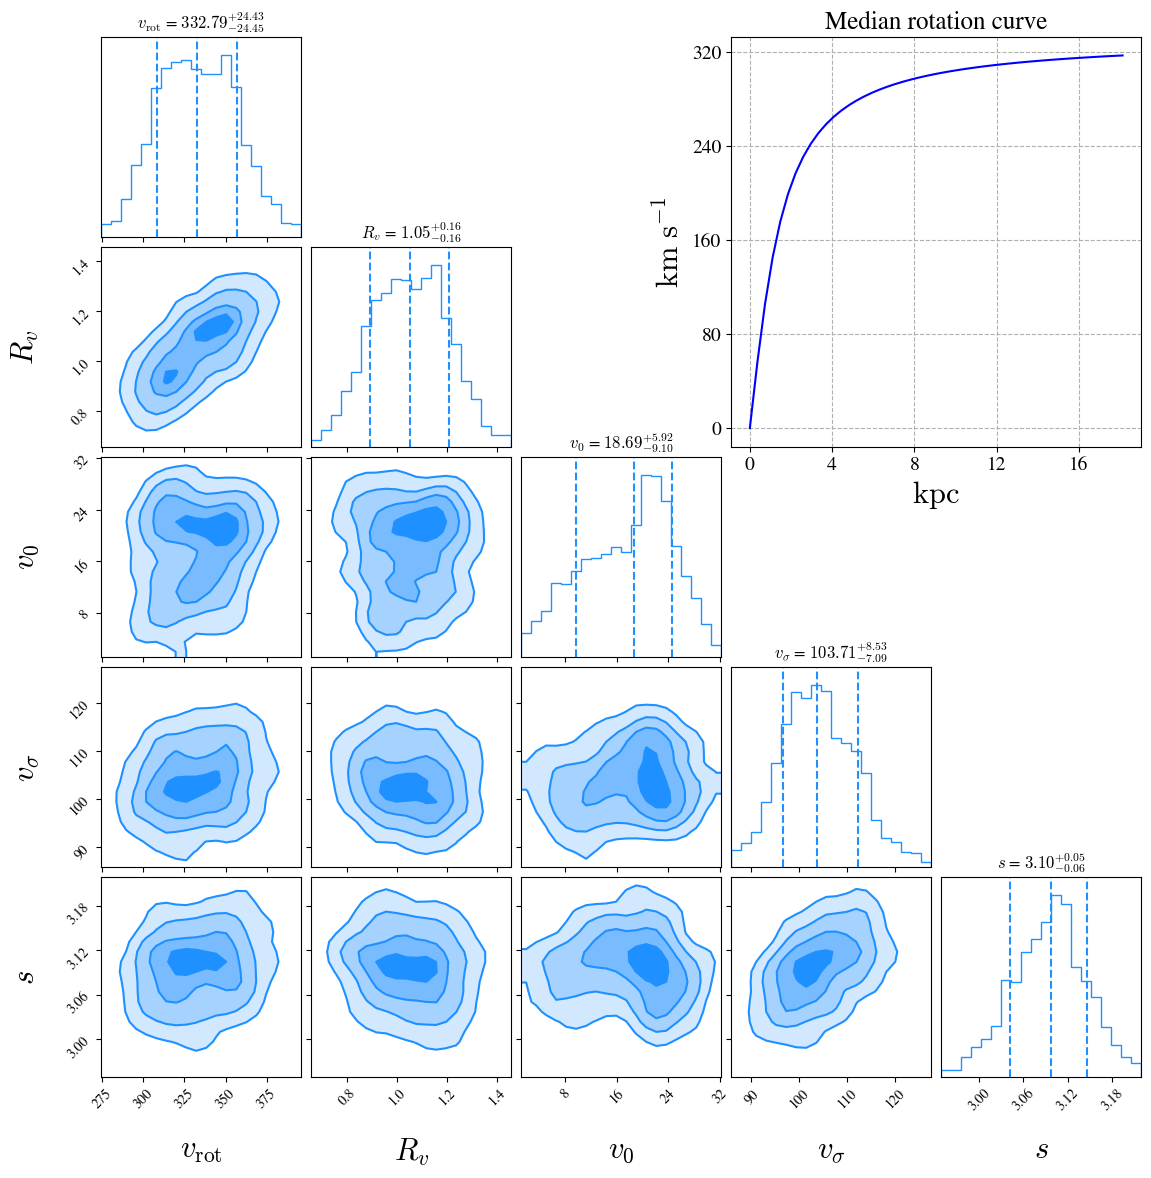

In [46]:
import corner

burnin = 100
samples = sampler.chain[:, int(burnin):, :].reshape((-1, Ndim))
flat_chain = samples.copy()
flat_chain[:,1] = (flat_chain[:,1]*0.03*u.arcsec/cosmos.arcsec_per_kpc_proper(8.34)).value

fig = corner.corner(flat_chain, labels=[r'$v_{\rm rot}$',r'$R_v$','$v_0$',r'$v_\sigma$','$s$'], 
                    plot_datapoints=False, fill_contours=True, color="dodgerblue", smooth=1.,
                    quantiles=[0.16, 0.5, 0.84], # on marginalized histogram
                range=[0.99,0.99,0.99,0.99,0.99],show_titles=True,label_kwargs={'fontsize':22},
                   )

gs = fig.axes[3].get_gridspec()

for ax in np.array(fig.axes)[[3,4,8,9]]:
    ax.remove()

ax = fig.add_subplot(gs[:2, 3:])

Rv = params_fit[1]
vrot = params_fit[0]
R = np.linspace(0,100,50)
v = abs(2*vrot/np.pi*np.arctan(R/Rv))

ax.plot(R*0.03*u.arcsec/cosmos.arcsec_per_kpc_proper(5.4),v,c='b')

ax.set_xlabel(r'$\rm kpc$',fontsize=22)
ax.set_ylabel(r'$\rm km\ s^{-1}$',fontsize=22)
ax.spines['left'].set_visible(True)
ax.grid(ls='--')
ax.yaxis.set_major_locator(
                        MaxNLocator(5, prune="lower")
                    )
ax.xaxis.set_major_locator(
                        MaxNLocator(5, prune="lower")
                    )
ax.axes.set_frame_on(True)
ax.set_title('Median rotation curve',fontsize=18)
ax.tick_params(axis='both', labelsize=14)

# plt.savefig('rot_model_mcmc.pdf',bbox_inches='tight')